In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os

import warnings
warnings.filterwarnings("ignore")

import torch
import torch.nn as nn

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

from torchvision.models import resnet50, ResNet50_Weights

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from PIL import Image
from copy import deepcopy

In [8]:
def create_df(path):
    dd = {"images": [], "labels": []}
    
    for i in os.listdir(path):
        img_dirs = os.path.join(path, i)
        for j in os.listdir(img_dirs):
            dd["images"] += [os.path.join(img_dirs, j)]
            dd["labels"] += [i]
            
    return pd.DataFrame(dd)

# Creation of the dataset
## Importing data

In [9]:
df = create_df("/kaggle/input/covid19-image-dataset/Covid19-dataset/train")
test = create_df("/kaggle/input/covid19-image-dataset/Covid19-dataset/train")

## Encoding labels and shuffling test set for further evaluation of trained model

In [17]:
le = LabelEncoder()

df["labels"] = le.fit_transform(df["labels"].values)
test["labels"] = le.transform(test["labels"].values)

test = test.sample(frac=1).reset_index(drop=True)


# Training hyper-parameters

In [18]:
EPOCHS = 20
LR = 0.1
GAMMA = 0.1
STEP = 10
BATCH = 32
IMG_SIZE = 224
OUT_SIZE = 3

# Data pre-processing and Training

In [19]:
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models
from sklearn.model_selection import train_test_split
from PIL import Image
import numpy as np
from copy import deepcopy

# Splitting the dataset
train, val = train_test_split(df.values, random_state=42, test_size=0.2)

# Dataset pipeline with data augmentation
class Pipeline(Dataset):
    def __init__(self, data, transform):
        super().__init__()
        self.data = data
        self.transform = transform
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, x):
        img, label = self.data[x, 0], self.data[x, 1]
        img = Image.open(img).convert("RGB")
        img = self.transform(img)
        label = torch.tensor(label, dtype=torch.long)  # Convert label to tensor
        return img, label
# Data augmentation and normalization
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Datasets and dataloaders
train_ds = Pipeline(train, transform)
val_ds = Pipeline(val, transform)

train_dl = DataLoader(train_ds, batch_size=BATCH, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=BATCH, shuffle=False)

# Model setup
resnet = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)
resnet.fc = nn.Linear(resnet.fc.in_features, OUT_SIZE)

class COVID_Detector(nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model
        
    def forward(self, x):
        return torch.softmax(self.model(x), dim=1)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = COVID_Detector(resnet).to(device)

# Loss, optimizer, and scheduler
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=LR, momentum=0.9)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=STEP, gamma=GAMMA)

# Training loop
best_model = deepcopy(model)
best_acc = 0

for epoch in range(EPOCHS):
    model.train()
    train_loss, train_acc = 0, 0
    
    for data, target in train_dl:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        out = model(data)
        loss = criterion(out, target)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_acc += (out.argmax(1) == target).sum().item()

    train_loss /= len(train_dl.dataset)
    train_acc /= len(train_dl.dataset)
    
    model.eval()
    val_loss, val_acc = 0, 0
    
    with torch.no_grad():
        for data, target in val_dl:
            data, target = data.to(device), target.to(device)
            out = model(data)
            loss = criterion(out, target)
            
            val_loss += loss.item()
            val_acc += (out.argmax(1) == target).sum().item()

    val_loss /= len(val_dl.dataset)
    val_acc /= len(val_dl.dataset)

    if val_acc > best_acc:
        best_acc = val_acc
        best_model = deepcopy(model)
    
    print(f"Epoch {epoch+1} train loss {train_loss:.4f} acc {train_acc:.4f} val loss {val_loss:.4f} acc {val_acc:.4f}")
    
    scheduler.step()


Epoch 1 train loss 0.0366 acc 0.4100 val loss 0.0386 acc 0.5882
Epoch 2 train loss 0.0287 acc 0.7050 val loss 0.0404 acc 0.4706
Epoch 3 train loss 0.0234 acc 0.9100 val loss 0.0327 acc 0.7059
Epoch 4 train loss 0.0221 acc 0.9300 val loss 0.0314 acc 0.7059
Epoch 5 train loss 0.0247 acc 0.8750 val loss 0.0464 acc 0.2941
Epoch 6 train loss 0.0236 acc 0.8650 val loss 0.0428 acc 0.4118
Epoch 7 train loss 0.0242 acc 0.8500 val loss 0.0368 acc 0.5882
Epoch 8 train loss 0.0228 acc 0.9000 val loss 0.0444 acc 0.4314
Epoch 9 train loss 0.0222 acc 0.9200 val loss 0.0304 acc 0.8039
Epoch 10 train loss 0.0215 acc 0.9500 val loss 0.0253 acc 0.9020
Epoch 11 train loss 0.0204 acc 0.9650 val loss 0.0233 acc 0.9608
Epoch 12 train loss 0.0206 acc 0.9650 val loss 0.0234 acc 0.9412
Epoch 13 train loss 0.0202 acc 0.9700 val loss 0.0240 acc 0.9216
Epoch 14 train loss 0.0215 acc 0.9450 val loss 0.0244 acc 0.9216
Epoch 15 train loss 0.0206 acc 0.9750 val loss 0.0243 acc 0.9412
Epoch 16 train loss 0.0197 acc 0.9

# Predicting test images for further model evaluation

In [22]:
# Ensure the model is in evaluation mode
best_model.eval()

# Initialize lists to store the ground truth, predictions, and probabilities
truth = []
probas = []
preds = []

# Define the predict function to handle a single image prediction
def predict(img_path):
    img = Image.open(img_path).convert("RGB")
    img_tensor = transform(img).unsqueeze(0)  # Add batch dimension [1, 3, 224, 224]
    
    if torch.cuda.is_available():
        img_tensor = img_tensor.cuda()
        
    with torch.no_grad():
        out = best_model(img_tensor)
        prob = torch.softmax(out, dim=1)  # Apply softmax to get probabilities
        index = prob.argmax(dim=1).item()  # Get the predicted class index
        
    return index, prob[0][index].item()

# Loop through the test dataset and collect predictions
for i in range(test.shape[0]):
    img_path = test.iloc[i, 0]
    true_label = test.iloc[i, 1]
    
    pred, proba = predict(img_path)
    
    truth.append(true_label)
    preds.append(pred)
    probas.append(proba * 100)  # Store the probability as a percentage

# Now `truth`, `preds`, and `probas` contain the true labels, predicted labels, and prediction probabilities


# Predicted results for test set - Evaluation metrics scores

              precision    recall  f1-score   support

           0       0.99      0.97      0.98       113
           1       0.91      0.96      0.93        67
           2       0.96      0.94      0.95        71

    accuracy                           0.96       251
   macro avg       0.95      0.96      0.96       251
weighted avg       0.96      0.96      0.96       251



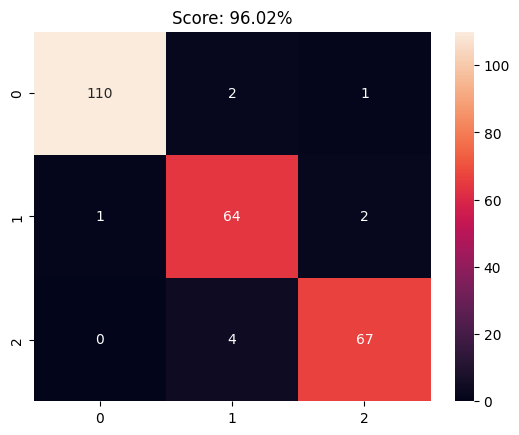

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

print(classification_report(preds, truth))
sns.heatmap(confusion_matrix(preds, truth), annot=True, fmt='d')
plt.title("Score: {}%".format(round(accuracy_score(preds, truth)*100, 2)))
plt.show()

# Visual inspection of predicted test results

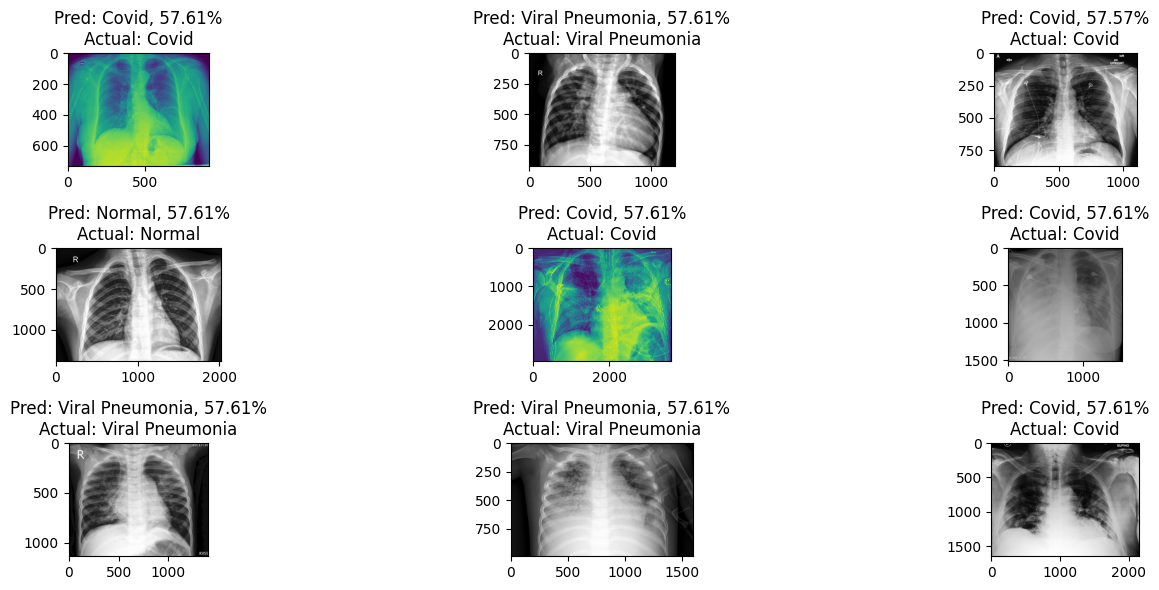

In [ ]:
index = 0

truth_labels = le.inverse_transform(np.array(truth))
pred_labels = le.inverse_transform(np.array(preds))

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 6))

for i in range(3):
    for j in range(3):
        axes[i][j].imshow(np.array(Image.open(test.iloc[index, 0])))
        axes[i][j].set_title("Pred: {}, {}%\nActual: {}".format(pred_labels[index], round(probas[index], 2), truth_labels[index]))
        index += 1
        
plt.tight_layout()
plt.show()